In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt 
from scipy.stats.distributions import chi2
from statsmodels.tsa.arima_model import ARMA
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

In [2]:
raw_data = pd.read_csv("../data/Index2018.csv")
df_comp = raw_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst=True)
df_comp.set_index("date", inplace=True)
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method='ffill')

In [3]:
df_comp['market_value'] = df_comp.ftse
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']

size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size].copy(), df_comp.iloc[size:].copy()

# LLR Test

In [4]:
def LLR_test(mod_1, mod_2, DF=1):
    # DF: degrees of freedom
    
    # log likelihood
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    
    # test statistic
    LR = (2 * (L2 - L1))
    p = chi2.sf(LR, DF).round(3)
    
    return p

# The DF-Test

In [5]:
sts.adfuller(df.market_value)

(-1.904155141883687,
 0.330108932770283,
 6,
 5014,
 {'1%': -3.4316548765428174,
  '5%': -2.8621166146845334,
  '10%': -2.5670769326348926},
 54854.15304507557)

The p-value of 0.33 indicates that ftse does not come from a stationary process. We cannot use AR models to non-stationary process. Therefore, we introduce a new concept called Return which is more likely to be stationary.

# Using Returns

Returns in finance means the percentage change between two consecutive periods.

$$
\frac{P_t - P_{t-1}}{P_{t-1}} \times 100
$$

We can use this instead of the raw data to apply the AR models.

In [6]:
df['returns'] = df.market_value.pct_change(1).mul(100)
df = df.iloc[1:] # because the first value in returns is null

In [7]:
sts.adfuller(df.returns)

(-12.770265719497232,
 7.79805833603833e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 15696.767245697501)

Given the p-value of 7.798e-24, we can say the new series 'returns' is a stationary process.

# ACF and PACF of Returns

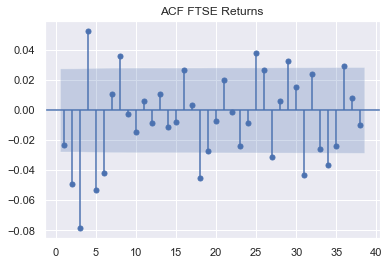

In [8]:
sgt.plot_acf(df.returns, zero=False)
plt.title("ACF FTSE Returns")
plt.show()

First we can notice that values for returns are greatly different from the ones for raw ftse data. Whereas the autocorrelation for the raw data was high throughout the all 40 lags, this only shows only a few (5 out of the first 6 lags) are significant. 

Also, we can notice consecutive values move different direction, from negative to positive or positive to negative. This indicates some form of natural adjustment occuring in the market. 


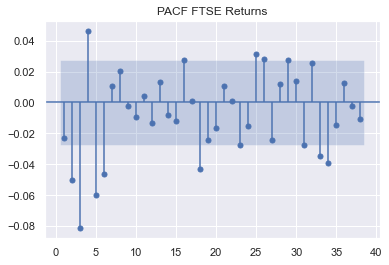

In [9]:
sgt.plot_pacf(df.returns, zero=False, method=('ols'))
plt.title("PACF FTSE Returns")
plt.show()

This looks very similar to the ACF.

# AR(1) for Returns

In [11]:
model_ret_ar_1 = ARMA(df.returns, order=(1, 0))
results_ret_ar_1 = model_ret_ar_1.fit()
results_ret_ar_1.summary()

/Users/minkyung/Dropbox/mk-personal-repo/snp500-analysis/venv-snp/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 0)   Log Likelihood               -7929.749
Method:                       css-mle   S.D. of innovations              1.174
Date:                Thu, 14 Jan 2021   AIC                          15865.497
Time:                        23:08:17   BIC                          15885.061
Sample:                    01-10-1994   HQIC                         15872.353
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.016      1.159      0.247      -0.013       0.051
ar.L1.returns    -0.0230      0.014     -1.631      0.103      -0.051       0.005
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -43.4386           +0.0000j           43.4386            0.5000
-----------------------------------------------------------------------------
"""

The both p-values are greater than 0.05, meaning neither of them is significantly different from 0 and this model has no predictive power. So, we would want to test higher lag models serve as a better predictor. 

Keep in mind that the more easily yesterday's price is affected by higher lags, the more inaccurate its coefficient becomes, and less predictive power it has.

# Higher-Lag AR Models for Returns

In [13]:
model_ret_ar_2 = ARMA(df.returns, order=(2, 0))
results_ret_ar_2 = model_ret_ar_2.fit()
results_ret_ar_2.summary()

/Users/minkyung/Dropbox/mk-personal-repo/snp500-analysis/venv-snp/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(2, 0)   Log Likelihood               -7923.456
Method:                       css-mle   S.D. of innovations              1.173
Date:                Thu, 14 Jan 2021   AIC                          15854.911
Time:                        23:15:51   BIC                          15880.996
Sample:                    01-10-1994   HQIC                         15864.052
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.015      1.220      0.222      -0.011       0.049
ar.L1.returns    -0.0242      0.014     -1.716      0.086      -0.052       0.003
ar.L2.returns    -0.0500      0.014     -3.550      0.000      -0.078      -0.022
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.2417           -4.4635j            4.4701           -0.2586
AR.2           -0.2417           +4.4635j            4.4701            0.2586
-----------------------------------------------------------------------------
"""

In [14]:
LLR_test(model_ret_ar_1, model_ret_ar_2, DF=1)

0.0

AR(2) is better than AR(1) because 
- (1) the last coefficient is significant 
- (2) Log likelihood test passes (<0.05)
- (3) Information criteria (AIC, BIC) are lower

We keep increasing the number of lags until we find a model that does not meet the above criteria. It 

In [15]:
model_ret_ar_6 = ARMA(df.returns, order=(6, 0))
results_ret_ar_6 = model_ret_ar_6.fit()
results_ret_ar_6.summary()

/Users/minkyung/Dropbox/mk-personal-repo/snp500-analysis/venv-snp/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(6, 0)   Log Likelihood               -7886.945
Method:                       css-mle   S.D. of innovations              1.164
Date:                Thu, 14 Jan 2021   AIC                          15789.890
Time:                        23:20:23   BIC                          15842.059
Sample:                    01-10-1994   HQIC                         15808.170
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.414      0.157      -0.007       0.045
ar.L1.returns    -0.0245      0.014     -1.740      0.082      -0.052       0.003
ar.L2.returns    -0.0523      0.014     -3.716      0.000      -0.080      -0.025
ar.L3.returns    -0.0870      0.014     -6.174      0.000      -0.115      -0.059
ar.L4.returns     0.0424      0.014      3.009      0.003       0.015       0.070
ar.L5.returns    -0.0607      0.014     -4.309      0.000      -0.088      -0.033
ar.L6.returns    -0.0466      0.014     -3.302      0.001      -0.074      -0.019
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2869           -0.9022j            1.5716           -0.0973
AR.2            1.2869           +0.9022j            1.5716            0.0973
AR.3           -0.0727           -1.5282j            1.5299           -0.2576
AR.4           -0.0727           +1.5282j            1.5299            0.2576
AR.5           -1.8659           -0.4836j            1.9275           -0.4596
AR.6           -1.8659           +0.4836j            1.9275            0.4596
-----------------------------------------------------------------------------
"""